In [1]:
from datetime import datetime, timedelta, date, time
import pandas as pd
import numpy as np
import fredpy as fpew
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px
from scipy import signal
import statsmodels.api as sm

In [2]:
#Read in the data downloaded from google trends
df = pd.read_csv('./data/trend_data.csv',index_col='date',parse_dates=True)
kw_list = list(df.columns)
print(kw_list)

#Plot the data
fig = px.line(df, x=df.index, y=kw_list, title='Series from google trends')
fig.show()  

['recession', 'unemployment', 'unemployment benefits', 'job postings', 'inflation']


In [3]:
#prepare the input series (x) by detrending and standardizing
x = StandardScaler().fit_transform(signal.detrend(df))

#Calculate the first 3 principal components & output explained variance
pca = PCA(n_components=3)
df_PC = pca.fit_transform(x)
print(pca.explained_variance_ratio_)

[0.6111988  0.37502643 0.01377477]


In [8]:
#add estimation data and result to a dataframe
df_est = pd.DataFrame(np.concatenate((df_PC, x), axis=1))

# collect and add column names to the estimation data
kw_list_std = [kw +"_std" for kw in kw_list]
colnames = ["PC1","PC2","PC3"]
colnames.extend(kw_list_std);
df_est.columns = colnames

#add back to original data, so we have the complete dataset
df_temp = df.reset_index(drop=False)
df_panel = pd.concat([df_temp, df_est.reset_index(drop=True)], axis =1)

df_panel['date'] = pd.to_datetime(df_panel['date'])
df_panel= df_panel.set_index(['date'])

In [9]:
fig = px.line(df_panel, x="date", y=["PC1","PC2",'PC3'], title='Principal Components')
fig.show()

ValueError: Value of 'x' is not the name of a column in 'data_frame'. Expected one of ['recession', 'unemployment', 'unemployment benefits', 'job postings', 'inflation', 'PC1', 'PC2', 'PC3', 'recession_std', 'unemployment_std', 'unemployment benefits_std', 'job postings_std', 'inflation_std'] but received: date

PAYNSA
PAYEMS


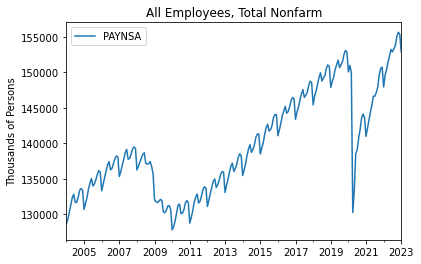

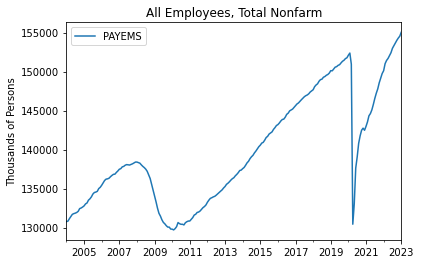

In [6]:
from fredapi import Fred
import config

#This is my custom function for fred downloads
# User will need a FRED API key, can sign up for one here https://fred.stlouisfed.org/docs/api/api_key.html
# replace with your own API key: fred = Fred(api_key='YOUR KEY HERE')
fred = Fred(api_key=config.api_key)

"""
DEFINE: fredget() => a function to retrieve series, store info, and plot data 
-----------------------INPUTS -------------------------------
varlist: a list of FRED codes ex. FRED_list = ['GDP','SP500']
start_date & end_date: set the chosen sample ex. start_d ='1990-01-01'
plots (Optional): True/False => set whether to show a preview of the data during collection
freq (Optional): default is not to synchronize frequencies: choose 'm','q','a' if aggregating
name_map (Optional):dict containing remapped variable names for plot default titles
------------------------OUTPUTS -----------------------------
df_collect: the compiled data df with date set as index
info_store: DF containing series info (units, titles, notes, etc.)
"""

def fredget(varlist, start_date, end_date, plots=True,freq="",name_map = dict(),trans_dict=dict()):
    df_collect = pd.DataFrame()
    
    shift_dict = {'W':52,'M':12,'Q':4}
    
    for var in varlist:
        df_add = fred.get_series(var, observation_start = start_date, observation_end=end_date, frequency =freq).to_frame(name = var)
        info_add = fred.get_series_info(var).to_frame(name = var)
        print(var)
       
        #If user changes the freq
        if freq != "":
            info_add.loc['cur_freq', var] = freq
         
        if var in trans_dict:   
            if trans_dict[var] == 'apc':
                freq_var = info_add.loc['frequency_short', var] 
                df_add[var] = df_add[var].pct_change(shift_dict[freq_var])
                info_add.loc['units', var] ='Annual % Change'
                info_add.loc['units_short', var] ='12m %'
            
        if var in name_map:
            info_add.loc['user_title', var] = name_map[var]
        else:
            info_add.loc['user_title', var] = info_add.loc['title', var]
                    
        if plots == True:
            df_add.plot(y=var, use_index=True, kind='line', title = info_add.loc['user_title', var], ylabel = info_add.loc['units', var] )
            
        if df_collect.empty == True:
            df_collect = df_add
            info_store = info_add
        else:
            df_collect = pd.merge(df_collect, df_add, left_index=True, right_index=True, how='outer')
            info_store = pd.merge(info_store, info_add, left_index=True, right_index=True, how='left')
            
    df_collect.sort_index()
    return df_collect, info_store

#Collect the data
s_d ='2004-01-01'
e_d='2023-01-01'
labor_list = ['PAYNSA','PAYEMS']
df_fred, fred_info = fredget(labor_list, s_d, e_d, plots=True,freq="m")


In [27]:
df = pd.merge(df_fred,df_panel,left_index=True, right_index=True)
for var in labor_list:
    df[var] = df[var].pct_change(periods = 12)
df['year'] = df.index.year
fig = px.line(df, x=df.index, y=labor_list, title='Variables of interest')
fig.show()

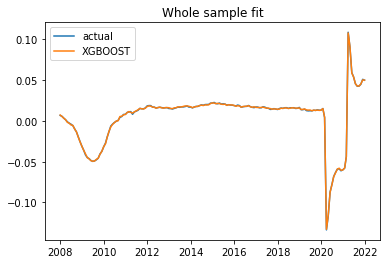

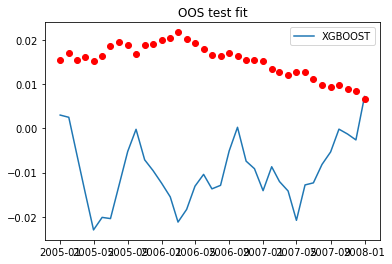

In [31]:
from matplotlib import pyplot as plt 
import xgboost as xgb


reglist = ['PC1','PC2','PC3']
varlist = reglist.copy()
for f in reglist:
    for i in range(1,24):
        varname = f'{f}_L_{i}'
        varlist.append(varname)
        df[varname] = df[f].shift(i) 
        

df_train = df.loc['2008-1-1':'2022-1-1']

varlist.append('year')

x = df_train[varlist]
y = df_train['PAYEMS']

'''XGBOOST BEGINS HERE'''
#not yet tuned
regressor = xgb.XGBRegressor(
    n_estimators=100,
    reg_lambda=1,
    gamma=0,
    max_depth=3
)

#Compute XGB fit
regressor.fit(x, y)
xgpred = regressor.predict(x)
xg_df = pd.DataFrame(xgpred, columns = ['xgfit'], index = df_train.index)

#Plot the in-sample fit 
plt.plot(y,label="actual")
plt.plot(xg_df['xgfit'],label="XGBOOST")
plt.legend()
plt.title('Whole sample fit')

#Set up a test time period 
df_test = df.loc['2005-1-1':'2008-1-1']
y_test = df_test['PAYEMS']
x_test = df_test[varlist]
xgpred_test = regressor.predict(x_test)
xg_df_test = pd.DataFrame(xgpred_test, columns = ['xgfit'], index = df_test.index)

#Plot the out of sample fits 
plt.figure()

plt.plot(xg_df_test,label="XGBOOST")
plt.legend()
plt.title('OOS test fit')
plt.plot(df_test['PAYEMS'], 'ro')

# #Plot the Error Conditional on the weeks to GDP release
# df_test = df_test.merge(ols_df,left_index=True,right_index=True, how='left')
# df_test = df_test.merge(xg_df_test,left_index=True,right_index=True, how='left')
# df_test['ols_err'] = abs(df_test['gdp_lag0'] - df_test['ols'])
# df_test['xg_err'] = abs(df_test['gdp_lag0'] - df_test['xgfit'])
# df_plot_err = df_test.groupby(['count']).mean()

# for type in ['ols','xgfit']:
#     df_plot_err.plot(y=type,title=type)
    

